# Deep Sets vs RNN

**Plan:** Just make a quick plot of one of my well performing Deep Sets models compared to the RNN performance.

### Step 1: Load in the data

Actually, maybe I don't need to load in data if I've already saved ROC curves?

In [2]:
import numpy as np
import h5py
import sys
import pandas as pd
import xarray as xr

sys.path.append("../..")
from usefulFcts import *
from trainNet import *
from plottingFcts import *

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


In [3]:
subDir = 'mc16d_PFlow_ttbar'
dataDir = '../../data/' + subDir
vStr = "sd0_sz0_nNextToInnHits_nInnHits_nsharedBLHits_nsplitBLHits_nsharedPixHits_nsplitPixHits_nsharedSCTHits_logNorm_ptfrac_dr_norm_nPixHits_nSCTHits"
dataTagTrain = "3mtrain_15trks_{}".format(vStr)
dataTagTest  = "2mtest_15trks_{}_sd0_rev".format(vStr)

f_name = "{}/data_{}.hdf5".format(dataDir,dataTagTest)
f = h5py.File(f_name,"r")

X = f['X_test'][:]
y = f['y_test'][:]
ix = f['ix_test'][:]

f.close()

### Step 2: Load in the models

According to my `Hyperparameter-Scan` notebook, it looks like the most performant model was

$\Phi$: 100-64, $F$: 100-100-100

Initialize method from myModel()
Loading previously trained LSTM
min: -6.61, max: 11.12


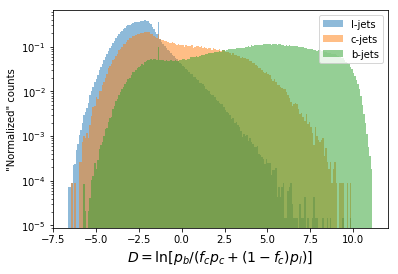

Initialize method from myModel()
Loading previously trained PFN
Load in the previously saved efficiency file


In [4]:
leffs, ceffs, beffs = [],[],[]

modelDir = '../../models/'+subDir
figDir = '../../figures/'
nTest, nTrks, nFeatures = X.shape

# LSTM
dataTagTrain = "3mtrain_15trks_{}_sd0_rev".format(vStr)
m = myLSTM(modelDir=modelDir, nFeatures=nFeatures, dataTag=dataTagTrain, loadModel=True)
leff, ceff, beff = sigBkgEff(m, X, y, ix,figDir=figDir,subDir=subDir,modelDir=modelDir)

leffs.append(leff)
ceffs.append(ceff)
beffs.append(beff)

# PFN
dense_sizes = [100] * 3
ppm_sizes = [100,100,128]
dataTagTrain = "2mtrain_15trks_{}".format(vStr)
m = myPFN(ppm_sizes, dense_sizes, latent_dropout=0,
          timeSteps=nTrks, nFeatures=nFeatures,
          modelDir=modelDir, dataTag=dataTagTrain, loadModel=True)
leff, ceff, beff = getEffs(m, X, y, ix, figDir=figDir, 
                            subDir=subDir,modelDir=modelDir)


leffs.append(leff)
ceffs.append(ceff)
beffs.append(beff)

### Step 3: Make the ROC curves

/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3_tf/lib/python3.6/site-packages/scipy/interpolate/_cubic.py:147: RuntimeWarning: divide by zero encountered in true_divide
  mk = (y[1:] - y[:-1]) / hk
/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3_tf/lib/python3.6/site-packages/scipy/interpolate/_cubic.py:165: RuntimeWarning: invalid value encountered in true_divide
  whmean = (w1/mk[:-1] + w2/mk[1:]) / (w1 + w2)
/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3_tf/lib/python3.6/site-packages/scipy/interpolate/_cubic.py:117: RuntimeWarning: invalid value encountered in multiply
  d = ((2*h0 + h1)*m0 - h0*m1) / (h0 + h1)
../../plottingFcts.py:578: RuntimeWarning: invalid value encountered in sqrt
  eff_err = lambda x, N: np.sqrt( x*(1-x) / N)
/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3_tf/lib/python3.6/site-packages/scipy/interpolate/_cubic.py:147: RuntimeWarning: invalid value encountered in true_divide
  mk = (y[1:] - y[:-1]) / hk


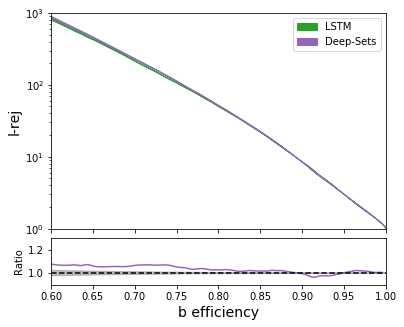

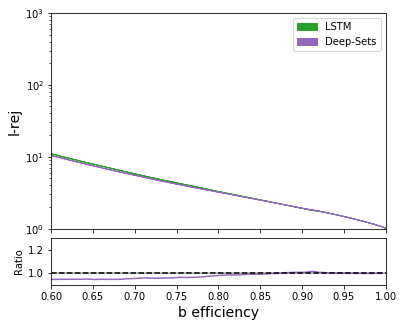

In [5]:
labels=['LSTM','Deep-Sets']

plotROCRatio(beffs, leffs, labels, rrange=(0.9,1.3),#text=text,
             ylabel='l-rej',binomialErrors=True,nTest=nTest,colors=['C2','C4'],
             figDir=figDir,subDir=subDir+'/deep-sets',tag='lrej_cf_lstm')

plotROCRatio(beffs, ceffs, labels, rrange=(0.9,1.3),#text=text,
             ylabel='l-rej',binomialErrors=True,nTest=nTest,colors=['C2','C4'],
             figDir=figDir,subDir=subDir+'/deep-sets',tag='crej_cf_lstm')




**Side note** For ease of comparison w/ CMS plots, look at plotting this as the ratio of efficiencies instead of the ratio of rejections. 

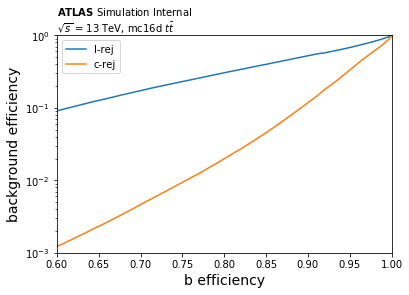

In [14]:
labels = ['l-rej','c-rej']
ylabel = 'background efficiency'

plotROC([beffs[0]]*2, [leffs[0],ceffs[0]], labels,
        ylabel=ylabel,ymin=0.001,ymax=1)